In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam

In [46]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from xgboost import XGBClassifier

# Data Exploration

In [47]:
data_path = os.path.join('/kaggle/input/covidx-cxr2')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')
train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)

In [48]:
val_data_path = os.path.join(data_path,'val')

val_df = pd.read_csv(os.path.join(data_path, 'val.txt'), sep=" ", index_col=None, header=None)


In [49]:
val_df.head()

,0,1,2,3
0,ANON196,CR.1.2.840.113564.1722810170.20200318082923328...,positive,actmed
1,ANON170,CR.1.2.840.113564.1722810170.20200320011259312...,positive,actmed
2,S03044,sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
3,S03044,sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
4,S03044,sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-...,positive,bimcv


In [50]:
train_df.head()

,0,1,2,3
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [51]:
train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)
val_df.drop(columns = [0,3], axis=1, inplace=True)

In [52]:
train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})
val_df=val_df.rename(columns = {1:'image_name', 2:'diagnosis'})

In [53]:
train_df.head()

,image_name,diagnosis
0,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative
1,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative
2,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative
3,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative
4,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative


In [54]:
train_df.diagnosis.value_counts()

diagnosis
positive    57199
negative    10664
Name: count, dtype: int64

In [55]:
val_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4232
Name: count, dtype: int64

In [56]:
train_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [57]:
train_df.duplicated().sum()

0

In [58]:
val_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [59]:
val_df.duplicated().sum()

0

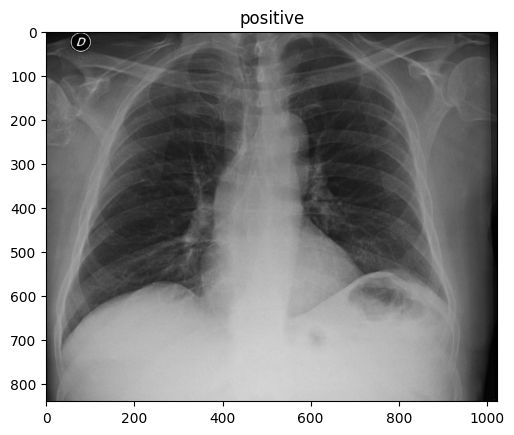

(839, 1024, 3)

In [60]:
rand_indx = np.random.randint(0,len(train_df),1)[0]
img = cv2.imread(os.path.join(train_data_path, train_df.image_name[rand_indx]))
plt.imshow(img/255)
plt.title(train_df.diagnosis[rand_indx])
plt.show()
img.shape


In [61]:
from sklearn.model_selection import train_test_split

In [62]:
train_df, df_test = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)

In [63]:
df_majority = train_df[train_df['diagnosis'] == 'positive']
df_minority = train_df[train_df['diagnosis'] == 'negative']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority), 
                                 random_state=42)

train_df = pd.concat([df_majority, df_minority_upsampled])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [64]:
train_df.diagnosis.value_counts()

diagnosis
positive    45759
negative    45759
Name: count, dtype: int64

In [65]:
df_test.diagnosis.value_counts()

diagnosis
positive    11440
negative     2133
Name: count, dtype: int64

In [66]:
def custom_preprocess(img):
    img = img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    mask = cv2.medianBlur(mask, 5)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.bitwise_and(img, mask)

    return img.astype(np.float32) / 255.0


In [67]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    rotation_range=15, zoom_range=0.1, horizontal_flip=True,
    width_shift_range=0.05, height_shift_range=0.05
).flow_from_dataframe(
    dataframe=train_df, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=val_df, directory=val_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)


Found 91518 validated image filenames belonging to 2 classes.
Found 8473 validated image filenames belonging to 2 classes.


In [79]:
test_datagen = ImageDataGenerator(preprocessing_function=custom_preprocess)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=train_data_path,
    x_col='image_name',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 18304 validated image filenames belonging to 2 classes.


# **EfficientNetB Model**

In [33]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [34]:
base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  

I0000 00:00:1746188173.054630      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [35]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
outputs = Dense(1, activation='sigmoid')(x)

In [36]:
model = Model(inputs, outputs)

In [37]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [39]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746188329.520885     119 service.cc:148] XLA service 0x7d43c0003140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746188329.523755     119 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746188333.168673     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2860 ━━━━━━━━━━━━━━━━━━━━ 3:32 74ms/step - accuracy: 0.3906 - loss: 1.0952   

I0000 00:00:1746188351.609959     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2834s 970ms/step - accuracy: 0.5030 - loss: 0.7353 - val_accuracy: 0.5009 - val_loss: 0.6933
Epoch 2/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2422s 845ms/step - accuracy: 0.5075 - loss: 0.6990 - val_accuracy: 0.5447 - val_loss: 0.6904
Epoch 3/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2324s 811ms/step - accuracy: 0.5066 - loss: 0.6968 - val_accuracy: 0.5619 - val_loss: 0.6904
Epoch 4/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2303s 804ms/step - accuracy: 0.5070 - loss: 0.6957 - val_accuracy: 0.5252 - val_loss: 0.6889
Epoch 5/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2246s 783ms/step - accuracy: 0.5088 - loss: 0.6950 - val_accuracy: 0.5721 - val_loss: 0.6867
Epoch 6/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2278s 795ms/step - accuracy: 0.5092 - loss: 0.6946 - val_accuracy: 0.5467 - val_loss: 0.6896
Epoch 7/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2264s 790ms/step - accuracy: 0.5131 - loss: 0.6934 - val_accuracy: 0.5545 - val_loss: 0.6878
Epoch 8/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2259s 788ms/step - accur

**Fine-tuning**

In [42]:
base_model.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


In [43]:
history_fine = model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=callbacks)

Epoch 1/5


E0000 00:00:1746211873.073943     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746211873.257853     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746211873.608964     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746211873.797482     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746211874.242529     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 413/2860 ━━━━━━━━━━━━━━━━━━━━ 30:38 751ms/step - accuracy: 0.6512 - loss: 0.6156

E0000 00:00:1746212246.539702     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746212246.724045     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746212247.075238     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746212247.262819     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746212247.697040     120 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2635s 859ms/step - accuracy: 0.8028 - loss: 0.4207 - val_accuracy: 0.7225 - val_loss: 0.5991
Epoch 2/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2375s 829ms/step - accuracy: 0.9197 - loss: 0.2229 - val_accuracy: 0.7800 - val_loss: 0.5018
Epoch 3/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2357s 822ms/step - accuracy: 0.9339 - loss: 0.1775 - val_accuracy: 0.7786 - val_loss: 0.5135
Epoch 4/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2315s 808ms/step - accuracy: 0.9435 - loss: 0.1490 - val_accuracy: 0.7612 - val_loss: 0.5789
Epoch 5/5
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2334s 814ms/step - accuracy: 0.9510 - loss: 0.1273 - val_accuracy: 0.7897 - val_loss: 0.5389


In [80]:
full_history = {}
for key in history.history:
    full_history[key] = history.history[key] + history_fine.history[key]

train_acc = full_history['accuracy'][-1]
val_acc = full_history['val_accuracy'][-1]
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.9527
Validation Accuracy: 0.7897


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


572/572 ━━━━━━━━━━━━━━━━━━━━ 288s 503ms/step - accuracy: 0.7987 - loss: 0.4599
Test Accuracy: 0.7976


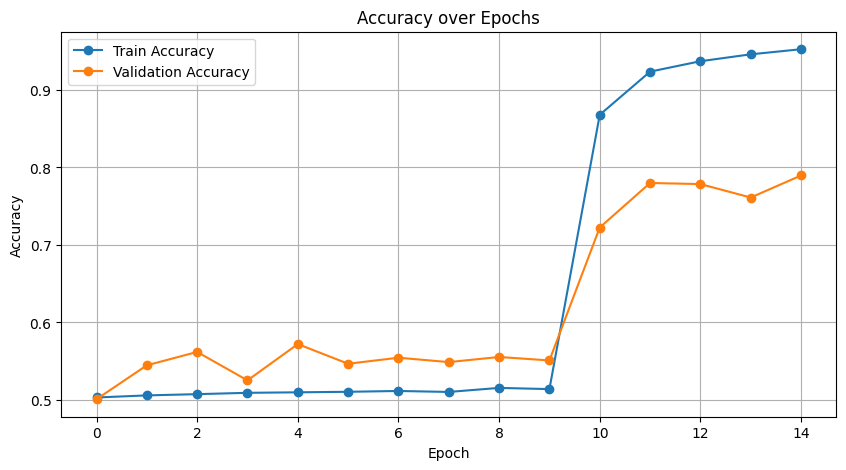

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(full_history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(full_history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

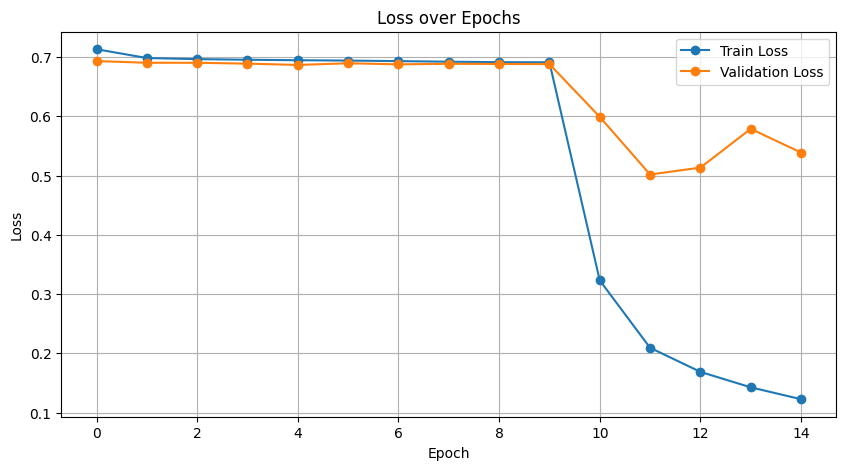

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(full_history['loss'], label='Train Loss', marker='o')
plt.plot(full_history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
from sklearn.metrics import roc_curve, auc


572/572 ━━━━━━━━━━━━━━━━━━━━ 251s 438ms/step


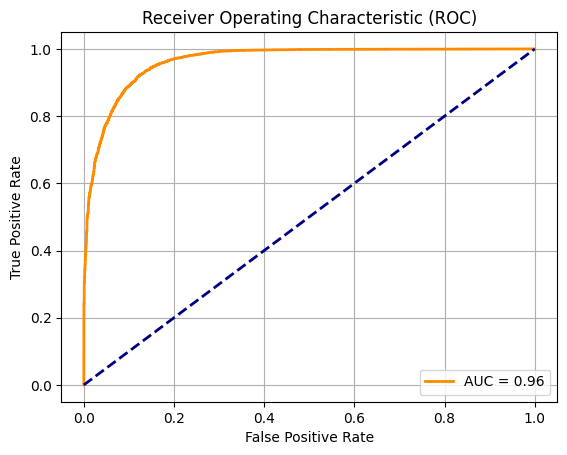

In [84]:
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen).ravel()

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [86]:
from sklearn.metrics import ConfusionMatrixDisplay


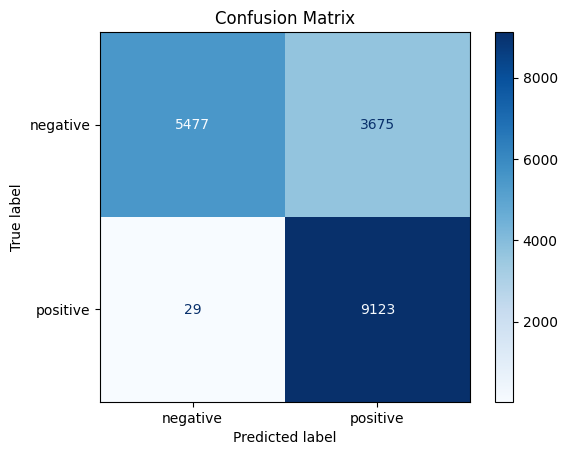

In [87]:
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


**Lime**

In [159]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [156]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
import cv2


In [ ]:
def predict_fn(images):
    images = np.array(images).astype(np.float32)
    return np.concatenate([1 - model.predict(images), model.predict(images)], axis=1)

idx = 0  
img_batch, label_batch = test_gen[idx]  
img = img_batch[0]  
true_label = int(label_batch[0])  

if img.shape[-1] == 1:
    img = np.repeat(img, 3, axis=-1)


img_for_lime = (img * 255).astype(np.uint8)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_for_lime,
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Original Image (Label: {true_label})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Explanation Mask (Top Label: {explanation.top_labels[0]})")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
img_path = "/kaggle/input/covidx-cxr2/train/000001-3.jpg"
last_conv_layer_name = "efficientnetb4"
run_gradcam(img_path, model, last_conv_layer_name)

**Grad-Cam**

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_path, model, preprocess_func, last_conv_layer_name='top_conv'):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_preprocessed = preprocess_func(img_rgb)
    img_array = np.expand_dims(img_preprocessed, axis=0)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Overlay")

    plt.tight_layout()
    plt.show()


In [ ]:
image_path = "/kaggle/input/covidx-cxr2/test/sub-S05073_ses-E12362_run-1_bp-chest_vp-pa_dx-corrected.png"
display_gradcam(image_path, model, custom_preprocess, last_conv_layer_name="top_conv")
